
# Estimating Income Processes

The permanent/transitory decomposition has held up well, but some questions remain. Scandinavian data provides us an unparalled opportunitity to measure this in more detail

In [1]:
# Initial imports and notebook setup, click arrow to show
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from min_distance import parameter_estimation, parameter_estimation_by_subgroup, vech_indices, implied_inc_cov_composite

In [37]:
#First load the moments
moments_BPP_dir = Path("../../Data/BPP_moments/") 
empirical_moments_all = np.genfromtxt(Path(moments_BPP_dir,"moments_all_c_vector.txt"), delimiter=',')
Omega_all =    np.genfromtxt(Path(moments_BPP_dir,"moments_all_omega.txt"), delimiter=',')
moments_CS_dir = Path("../../Data/CarrollSamwickMoments/") 
empirical_moments_CS_all = np.genfromtxt(Path(moments_CS_dir,"moments_all_c_vector.csv"), delimiter=',')
T=12
#Just doing income for now - remove other moments
income_moments = np.array([[False]*2*T]*2*T, dtype=bool)
income_moments[T:,T:] = True
vech_indices2T = vech_indices(2*T)
income_moments = income_moments[vech_indices2T]
empirical_moments_inc = empirical_moments_all[income_moments]
Omega_inc = Omega_all[income_moments,:][:,income_moments]

In [128]:
# set up initial guess and bounds
init_params = np.array([0.005,  #permanent variance
                        0.003,  #transitory variance
                        0.5,    #decay parameter of slightly persistant transitory shock
                        0.5,   #fraction of transitory variance that has no persistence
                        0.01])  # decay parameter of perm shock
optimize_index = np.array([True,  #permanent variance
                        True,  #transitory variance
                        True,    #decay parameter of slightly persistant transitory shock
                        True,   #fraction of transitory variance that has no persistence
                        False]) # decay parameter of perm shock (turned off for now)
bounds     = [(0.000001,0.1),
              (0.000001,0.1),
              (0.1,5.0),
              (0.0,1.0),
              (-0.1,0.1)]

In [141]:
# Do estimation for all population (25-55 or there abouts I think)
estimates, estimate_se = parameter_estimation(empirical_moments_inc, Omega_inc, T, init_params, bounds=bounds, optimize_index=optimize_index)  
implied_cov_full = implied_inc_cov_composite(estimates,T)
implied_cov = implied_cov_full[0:T]
implied_CS_moments = CS_from_BPP(implied_cov_full)[0:T]
# Get Carroll Samwick moments (just appropriate sum of BPP moments)
vech_indicesT = vech_indices(T)
def CS_from_BPP(BPP_moments):
    CS_moments = np.zeros((T,T))
    BPP_moments_matrix = np.zeros((T,T))
    BPP_moments_matrix[vech_indicesT] = BPP_moments
    BPP_moments_matrix[(vech_indicesT[1],vech_indicesT[0])] = BPP_moments
    for j in range(T):
        for i in np.array(range(T-j))+j:
            CS_moments[i,j] = np.sum(BPP_moments_matrix[j:i+1,j:i+1])
    CS_moments = CS_moments[vech_indicesT]
    return CS_moments
CS_moments = CS_from_BPP(empirical_moments_inc)
# Calculate mean empirical moments and standard errors
mean_moments = np.zeros(T)
mean_moments_se = np.zeros(T)
CS_moments_mean = np.zeros(T)
for t in range(T):
    this_diag = np.diag(1.0/(T-t)*np.ones(T-t),-t)
    this_diag = this_diag[vech_indicesT]
    mean_moments[t] = np.dot(this_diag,empirical_moments_inc)
    mean_moments_se[t] = np.dot(np.dot(this_diag,Omega_inc),this_diag)**0.5
    CS_moments_mean[t] = np.dot(this_diag,CS_moments)

In [163]:
# Set up plotting and widgets for understanding estimation
def plot_moments(perm_var,tran_var,half_life,bonus,perm_decay,compare="All Households",quantile=1):
    fig = plt.figure(figsize=(14, 9),constrained_layout=True)
    gs = fig.add_gridspec(2, 13)
    panel1 = fig.add_subplot(gs[0, 0:3])
    panel2 = fig.add_subplot(gs[0, 4:])
    #panel3 = fig.add_subplot(gs[1, 0:3])
    panel4 = fig.add_subplot(gs[1, 1:-2])
    
    panel1.plot(mean_moments[0:3], marker='o')
    panel2.plot(mean_moments, marker='o',label="Mean over all years")
    CS_Ndiff = np.array(range(T))+1.0
    CS_moments_factor = (CS_Ndiff-1.0/3.0)
    #panel3.plot(CS_Ndiff[0:3],CS_moments_mean[0:3]/CS_moments_factor[0:3], marker='o')
    panel4.plot(CS_Ndiff,CS_moments_mean/CS_moments_factor, marker='o',label="Mean over all years")
    # Standard errors
    panel1.plot(mean_moments[0:3]+1.96*mean_moments_se[0:3],linestyle="--",color="gray",linewidth=1.0)
    panel1.plot(mean_moments[0:3]-1.96*mean_moments_se[0:3],linestyle="--",color="gray",linewidth=1.0)
    panel2.plot(mean_moments+1.96*mean_moments_se,linestyle="--",color="gray",linewidth=1.0)
    panel2.plot(mean_moments-1.96*mean_moments_se,linestyle="--",color="gray",linewidth=1.0)
    
    #plot the moments for each year
    panel1.plot(empirical_moments_inc[0:3], marker='x',linewidth=0,color='#1f77b4')
    panel2.plot(np.array(range(T)),empirical_moments_inc[0:T], marker='x',linewidth=0,label="Individual years",color='#1f77b4')
    #panel3.plot(CS_Ndiff[0:3],CS_moments[0:3]/CS_moments_factor[0:3], marker='x',linewidth=0,color='#1f77b4')
    panel4.plot(CS_Ndiff[0:T],CS_moments[0:T]/CS_moments_factor, marker='x',linewidth=0,label="Individual years",color='#1f77b4')
    
    i = T
    for t in np.array(range(T-1))+1:
        panel1.plot(empirical_moments_inc[i:min(i+T-t,i+3)], marker='x',linewidth=0,color='#1f77b4')
        panel2.plot(np.array(range(T-t)),empirical_moments_inc[i:i+T-t], marker='x',linewidth=0,color='#1f77b4')
        #panel3.plot(CS_Ndiff[0:min(T-t,3)],CS_moments[i:min(i+T-t,i+3)]/CS_moments_factor[0:min(T-t,3)], marker='x',linewidth=0,color='#1f77b4')
        panel4.plot(CS_Ndiff[0:T-t],CS_moments[i:i+T-t]/CS_moments_factor[0:T-t], marker='x',linewidth=0,color='#1f77b4')
        i += T-t
    panel1.set_title('Variance and\n First Covariance', fontsize=17)
    panel2.set_title('Covariance $(\Delta y_t, \Delta y_{t+n})$ - BPP (2008)', fontsize=17)
    #panel3.set_title('First Few Variances', fontsize=17)
    panel4.set_title('Var$(\Delta^n y)/(n-1/3)$ - Carroll Samwick (1998)', fontsize=17)
    
    panel1.set_xlabel("Time Difference (n)", fontsize=15)
    panel2.set_xlabel("Time Difference (n)", fontsize=15)
    #panel3.set_xlabel("Time Difference (n)", fontsize=15)
    panel4.set_xlabel("Time Difference (n)", fontsize=15)
    
    panel1.set_ylabel("Covariance", fontsize=15)
    #panel2.set_ylabel("Covariance", fontsize=12)
    #panel3.set_ylabel("Variance", fontsize=15)
    panel4.set_ylabel("Var$(\Delta^n y)/(n-1/3)$", fontsize=15)
    
    panel1.axhline(y=0, color='k',linewidth=1.0)
    panel2.axhline(y=0, color='k',linewidth=1.0)
    #panel3.axhline(y=0, color='k',linewidth=1.0)
    panel4.axhline(y=0, color='k',linewidth=1.0)
    
    panel1.set_ylim(np.array([-0.0025,0.0125]))
    panel2.set_ylim(np.array([-0.0013,0.0003]))
    panel4.set_ylim(np.array([0.0,0.02]))
    #plot estimates
    panel1.plot(implied_cov[0:3], color="red")
    panel2.plot(implied_cov, color="red", label='Estimated')
    panel4.plot(CS_Ndiff,implied_CS_moments/CS_moments_factor, color="red", label='Estimated')
    
    
    #plot user defined
    omega = np.log(2)/half_life
    user_params = np.array([perm_var,tran_var,omega,bonus,perm_decay])
    user_cov_full = implied_inc_cov_composite(user_params,T)
    user_cov = user_cov_full[0:T]
    user_CS_moments = CS_from_BPP(user_cov_full)[0:T]   
    
    user_panel1, = panel1.plot(user_cov[0:3], color="orange")
    user_panel2, = panel2.plot(user_cov, color="orange", label='User')
    panel4.plot(CS_Ndiff,user_CS_moments/CS_moments_factor, color="orange", label='User')
    #comparison graph
    if (compare=="All Households"):
        panel1.plot(mean_moments[0:3],color='#1f77b4')
        panel2.plot(mean_moments,label="Compare To",color='#1f77b4')
        panel4.plot(CS_Ndiff,CS_moments_mean/CS_moments_factor,label="Compare To",color='#1f77b4')
        quantile_widget.options=['1']
    else:
        if (compare=="Liquid Wealth (quintiles)"):
            subgroup_stub='moments_by_liquid_wealth_quantile'
            quantile_widget.options=['1','2','3','4','5']
        elif (compare=="Net Wealth (quintiles)"):
            subgroup_stub='moments_by_net_wealth_quantile'
            quantile_widget.options=['1','2','3','4','5']
        elif (compare=="Income (deciles)"):
            subgroup_stub='moments_by_Income_quantile'
            quantile_widget.options=['1','2','3','4','5','6','7','8','9','10']
        elif (compare=="Net Nominal Position (deciles)"):
            subgroup_stub='moments_by_NNP_quantile'
            quantile_widget.options=['1','2','3','4','5','6','7','8','9','10']
        elif (compare=="Interest Rate Exposure (deciles)"):
            subgroup_stub='moments_by_URE_quantile'
            quantile_widget.options=['1','2','3','4','5','6','7','8','9','10']
        elif (compare=="Consumption (deciles)"):
            subgroup_stub='moments_by_MeanCons_quantile'
            quantile_widget.options=['1','2','3','4','5','6','7','8','9','10']
        subgroup_name = subgroup_stub+str(quantile)+"c_vector.txt"
        empirical_moments_subgroup_all = np.genfromtxt(Path(moments_BPP_dir,subgroup_name), delimiter=',')
        empirical_moments_subgroup_inc = empirical_moments_subgroup_all[income_moments]
        CS_moments_subgroup = CS_from_BPP(empirical_moments_subgroup_inc)
        mean_subgroup_moments = np.zeros(T)
        CS_mean_subgroup_moments = np.zeros(T)
        for t in range(T):
            this_diag = np.diag(1.0/(T-t)*np.ones(T-t),-t)
            this_diag = this_diag[vech_indicesT]
            mean_subgroup_moments[t] = np.dot(this_diag,empirical_moments_subgroup_inc)
            CS_mean_subgroup_moments[t] = np.dot(this_diag,CS_mean_subgroup_moments)
        panel1.plot(mean_subgroup_moments[0:3],color='#e377c2')
        panel2.plot(mean_subgroup_moments,label="Compare To",color='#e377c2')
        panel4.plot(CS_Ndiff,CS_mean_subgroup_moments/CS_moments_factor,label="Compare To",color='#e377c2')     
    panel2.legend(loc='lower right', prop={'size': 12})
    panel4.legend(loc='lower left', prop={'size': 12})
        



In [164]:
#set up widgets with default values
cont_update = False
perm_var_widget = widgets.FloatSlider(
    value=estimates[0],
    min=0,
    max=0.02,
    step=0.001,
    description='Perm Var',
    disabled=False,
    continuous_update=cont_update,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
)
tran_var_widget = widgets.FloatSlider(
    value=estimates[1],
    min=0,
    max=0.02,
    step=0.001,
    description='Tran Var',
    disabled=False,
    continuous_update=cont_update,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
)
half_life_widget = widgets.FloatSlider(
    value=np.log(2)/estimates[2],
    min=0,
    max=5.0,
    step=0.1,
    description='Tran Half Life',
    disabled=False,
    continuous_update=cont_update,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
bonus_widget = widgets.FloatSlider(
    value=estimates[3],
    min=0,
    max=1.0,
    step=0.05,
    description='Bonus',
    disabled=False,
    continuous_update=cont_update,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
perm_decay_widget = widgets.FloatSlider(
    value=estimates[4],
    min=-0.1,
    max=0.1,
    step=0.0003,
    description='Perm Decay',
    disabled=False,
    continuous_update=cont_update,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
)
reset_button = widgets.Button(description="Reset to estimated values",layout=widgets.Layout(width='80%', height='30px'))
def reset_button_clicked(b):
    perm_var_widget.value = estimates[0]
    tran_var_widget.value = estimates[1]
    half_life_widget.value = np.log(2)/estimates[2]
    bonus_widget.value = estimates[3]
    perm_decay_widget.value = estimates[4]
reset_button.on_click(reset_button_clicked)

compare_widget = widgets.Dropdown(
    options=['All Households',
             'Liquid Wealth (quintiles)',
             'Net Wealth (quintiles)',
             'Income (deciles)', 
             'Net Nominal Position (deciles)',
             'Interest Rate Exposure (deciles)',
             'Consumption (deciles)'],
    value='All Households',
    description='Compare To',
    disabled=False,
)
quantiles = ['1']
quantile_widget = widgets.Dropdown(
    options=quantiles,
    value='1',
    description='Quantile',
    disabled=False,
)
graph_update = widgets.interactive(plot_moments,
                                   perm_var=perm_var_widget,
                                   tran_var=tran_var_widget,
                                   half_life=half_life_widget,
                                   bonus=bonus_widget,
                                   perm_decay=widgets.fixed(0.01),
                                   compare=compare_widget,
                                   quantile=quantile_widget
)
control_widget=widgets.TwoByTwoLayout(
          bottom_left=reset_button,
          top_right=compare_widget,
          bottom_right=quantile_widget
)
slider_widget=widgets.TwoByTwoLayout(
          top_left=perm_var_widget,
          top_right=tran_var_widget,
          bottom_left = half_life_widget,
          bottom_right=bonus_widget
)

TwoByTwoLayout(children=(FloatSlider(value=0.008091175246665153, continuous_update=False, description='Perm Va…

TwoByTwoLayout(children=(Dropdown(description='Compare To', layout=Layout(grid_area='top-right'), options=('Al…

Output()

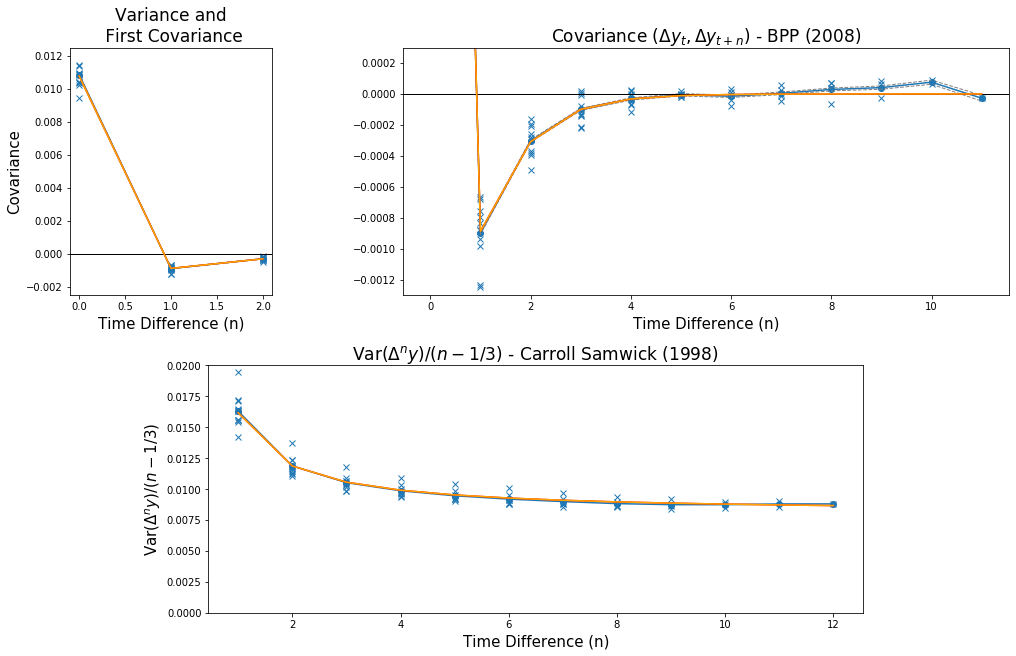

In [165]:
# plot moments
display( slider_widget )
display(control_widget)
graph_update.update()
graph_update.children[6]

In [42]:
# Esimtate parameters by quintiles of certain properties
def plot_by_subgroup(subgroup_stub, T, init_params, optimize_index=optimize_index, bounds=bounds):
    subgroup_names = []
    if (subgroup_stub=="Liquid Wealth (quintiles)"):
        subgroup_stub='moments_by_liquid_wealth_quantile'
        num_quantiles=5
    elif (subgroup_stub=="Net Wealth (quintiles)"):
        subgroup_stub='moments_by_net_wealth_quantile'
        num_quantiles=5
    elif (subgroup_stub=="Income (deciles)"):
        subgroup_stub='moments_by_Income_quantile'
        num_quantiles=10
    elif (subgroup_stub=="Net Nominal Position (deciles)"):
        subgroup_stub='moments_by_NNP_quantile'
        num_quantiles=10
    elif (subgroup_stub=="Interest Rate Exposure (deciles)"):
        subgroup_stub='moments_by_URE_quantile'
        num_quantiles=10
    elif (subgroup_stub=="Consumption (deciles)"):
        subgroup_stub='moments_by_MeanCons_quantile'
        num_quantiles=10
    for i in range(num_quantiles):
        subgroup_names += ["X"+str(i+1)]
    estimates, standard_errors = parameter_estimation_by_subgroup(moments_BPP_dir,subgroup_stub,subgroup_names, T, init_params, optimize_index=optimize_index, bounds=bounds)
    fig = plt.figure(figsize=(14, 7),constrained_layout=True)
    fig.figsize=(20,40)
    gs = fig.add_gridspec(2, 2)
    panel1 = fig.add_subplot(gs[0, 0])
    panel2 = fig.add_subplot(gs[0, 1])
    panel3 = fig.add_subplot(gs[1, 0])
    panel4 = fig.add_subplot(gs[1, 1])
    panel1.bar(np.array(range(num_quantiles))+1,estimates[:,0])
    panel2.bar(np.array(range(num_quantiles))+1,estimates[:,1])
    panel3.bar(np.array(range(num_quantiles))+1,np.log(2)/estimates[:,2])
    panel4.bar(np.array(range(num_quantiles))+1,estimates[:,3])
    panel1.set_title("Permanent Variance")
    panel2.set_title("Transitory Variance")
    panel3.set_title("Half-life of Somewhat Transitory Shock")
    panel4.set_title("Share that is Completely Transitory")
    panel1.set_xlabel("Quantile")
    panel2.set_xlabel("Quantile")
    panel3.set_xlabel("Quantile")
    panel4.set_xlabel("Quantile")
    
subgroup_widget = widgets.Dropdown(
    options=['Liquid Wealth (quintiles)',
             'Net Wealth (quintiles)',
             'Income (deciles)', 
             'Net Nominal Position (deciles)',
             'Interest Rate Exposure (deciles)',
             'Consumption (deciles)'],
    value='Income (deciles)',
    description='Subgroup',
    disabled=False,
)

In [43]:
# plot by different quantiles
widgets.interact(plot_by_subgroup,subgroup_stub=subgroup_widget, T=widgets.fixed(T), init_params=widgets.fixed(init_params), optimize_index=widgets.fixed(optimize_index), bounds=widgets.fixed(bounds));



interactive(children=(Dropdown(description='Subgroup', index=2, options=('Liquid Wealth (quintiles)', 'Net Wea…